<a href="https://colab.research.google.com/github/pomellonn/Risk_analytics/blob/main/t_intensiv_logreg_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Управление рисками 2026

## Часть 1. График линейности признака по WoE.

В этой части домашки мы познакомимся с одним из основных инструментов для анализа переменных в модели логистической регрессии - графиком линейности.

Кратко идею этого графика можно сформулировать так:
 - модель *линейной* регрессии корректно применять, если значение $y$ *линейно* связано со значением $x$. Иначе линрег не подходит для данной задачи и даст неверные результаты.
 - аналогичную проверку хочется сделать и для *логистической* регрессии. Но как проверить линейность, если таргет принимает всего два значения?
 - для этого необходимо преобразовать таргет: разбить признак на бакеты и в каждом бакете посчитать WoE
 - **линейность признака по WoE для логрега – аналог линейной связи признака и таргета для линрега**

Ниже пример признака с неплохой линейностью:

Нам нужно обратить внимание на 3 вещи:

**1. Фиолетовые точки с доверительными интервалами.**

Это WoE для каждого отдельного бакета. В идеале нам бы хотелось, чтобы **через эти точки можно было провести прямую линию** с небольшой погрешностью. Это и означает линейную взаимосвязь с таргетом.

**2. Синяя линия**

Попытка провести прямую линию через точки. Строится с помощью логистической регрессии на одной переменной. Затем предсказания переводятся в пространство WoE, отчего и получается прямая линия.

**3. Метрики в заголовке графика**

Метрики для признака:
 - roc auc, IV измеряют разделяющую способность переменной
 - $R^2$ измеряет *линейность взаимосвязи*. Признак считается линейным, если $R^2 \geq 0.95$

Далее напишем woe-line руками, чтобы в деталях разобраться, как он строится.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sps
from typing import Union, Tuple

In [ ]:
df = pd.read_csv('/content/lr_hw_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  100000 non-null  int64  
 1   feature_1   100000 non-null  float64
 2   feature_2   100000 non-null  float64
 3   feature_3   100000 non-null  float64
 4   feature_4   100000 non-null  float64
 5   feature_5   100000 non-null  float64
 6   feature_6   100000 non-null  float64
 7   feature_7   100000 non-null  int64  
 8   feature_8   100000 non-null  float64
 9   feature_9   100000 non-null  float64
 10  feature_10  100000 non-null  float64
 11  feature_11  100000 non-null  float64
 12  feature_12  100000 non-null  float64
 13  feature_13  100000 non-null  float64
 14  feature_14  100000 non-null  float64
 15  feature_15  100000 non-null  object 
 16  d4p12       100000 non-null  int64  
dtypes: float64(13), int64(3), object(1)
memory usage: 13.0+ MB


In [ ]:
df.head()

,Unnamed: 0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,d4p12
0,0,-1.444709,3.554779,1.308371,-0.000119,0.029628,3.829880,1,8.825418,3.829880,11.565953,-513.014565,-1.072893,7.936545,0.047069,B,1
1,1,1.132531,-0.207661,-2.142882,0.062686,0.859062,6.189545,1,3.453220,6.189545,4.935665,-39.351891,3.409855,17.015210,0.029288,A,0
2,2,1.268781,-0.243999,10000.000000,0.339225,0.614599,12.503629,1,-10.116061,12.503629,6.234414,-4.993050,3.121126,4.878602,0.237255,A,0
3,3,-1.278475,-2.579890,5.050763,-0.938956,0.090461,-1.080041,1,6.780814,-1.080041,2.682539,-509.273095,-1.242741,20.293025,0.907788,B,0
4,4,3.507807,0.152661,-8.905005,0.067646,0.216199,1.367184,1,-10.638134,1.367184,6.881602,-2.034797,2.814972,7.352399,0.276854,A,0


In [ ]:
df['Unnamed: 0']

,Unnamed: 0
0,0
1,1
2,2
3,3
4,4
...,...
99995,99995
99996,99996
99997,99997
99998,99998


In [ ]:
X = df.drop(['Unnamed: 0', 'd4p12'], axis=1)
y = df['d4p12']

### Шаг 0: разбиение на бакеты

In [ ]:
def calc_buckets(x : Union[np.ndarray, pd.Series], n_buckets : int) -> np.ndarray:
    """Разбивает массив значений признака x на
    n_buckets бакетов"""

    x = pd.Series(x).reset_index(drop=True)
    buckets = x.rank(method="dense", pct=True) * n_buckets
    buckets = np.ceil(buckets) - 1   # np.floor дает другой результат для 5.0, 6.0 и т.д.
    buckets = np.array(buckets, dtype=np.int16)

    return buckets

In [ ]:
# протестируйте calc_buckets
np.random.seed(42)
x = np.random.randn(100)

buckets = calc_buckets(x, n_buckets=5)

print(x[:10])
print(buckets[:10])
print(np.unique(buckets))
print(pd.Series(buckets).value_counts().sort_index())

[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]
[3 2 3 4 2 2 4 4 1 3]
[0 1 2 3 4]
0    20
1    20
2    20
3    20
4    20
Name: count, dtype: int64


### Шаг 1: расчет WoE по бакетам (2 балла)

Пусть $x_i \in \{ 0, 1\}^n$

$x_i$ - это вектор, состоящий из значений таргета *в одном бакете* $i$.

Для бакета можно посчитать количество единиц $B_i$ (bads, выпавшие в дефолт) и количество нулей $G_i$ (goods).

$$
B_i = \sum_{j \in x_i} \mathbb{I} \{ j = 1\}\quad G_i = \sum_{j \in x_i} \mathbb{I} \{ j = 0\}
$$

Также число бэдов и гудов можно посчитать и **для всей выборки**:

$$
% X = x_1 \cup x_2 \ldots \cup x_n
X = \{x_1,\; x_2\; \ldots\; x_n\}
$$

$$
B = \sum_{j \in X} \mathbb{I} \{ j = 1\}\quad G = \sum_{j \in X} \mathbb{I} \{ j = 0\}
$$

Тогда WoE можно посчитать как

$$
\text{WoE}_i(x) = \ln \Big ( \frac{B_i}{G_i} \Big ) - \ln \Big ( \frac{B}{G} \Big )
$$

**Задание**

Убедиться, что

$$
\text{WoE}_i(x) = \text{logit}(b_i) - \text{logit}(b)\quad  (1)
$$

где

$$
b = \frac{B}{B + G}\quad \text{logit}(p) = \ln \Big (  \frac{p}{1 - p} \Big )
$$

В дальнейшем будем считать WoE по формуле $(1)$

**Решение**

$$
  b = \frac{B}{B+G} \\ ⇒ 1 - b = 1 - \frac{B}{B+G} = \frac{B+G-B}{B+G} = \frac{G}{B+G}\\
 logit(b)= ln \left( \frac{b}{1 - b} \right) = ln \left( \frac{B}{(B+G)}\div \frac{G}{(B+G)}\right) = \ln \left( \frac{B}{G} \right)
$$
аналогично для $$logit(b_i)=\ln \left( \frac{B_i}{G_i}\right)$$
отсюда верно $(1)$

In [ ]:
from scipy.special import logit

def woe_transform(badrate : float, offset : float) -> float:
    """Считаем WoE для бакета с данным badrate и выборки
    с данным offset."""
    woe = logit(badrate) - offset
    return woe

Здесь и далее предлагается протестироать получившиеся функции. Нужно проверить, что
 - функция не ложится с ошибкой
 - возвращает то, что ожидается

In [ ]:
# протестируй woe_transform
def test_woe_transform_basic():
    B = 20
    G = 80
    total = B + G
    b_total = B / total
    offset = logit(b_total)

    B1 = 5
    G1 = 5
    badrate1 = B1 / (B1 + G1)

    B2 = 1
    G2 = 9
    badrate2 = B2 / (B2 + G2)

    woe1 = woe_transform(badrate1, offset)
    woe2 = woe_transform(badrate2, offset)

    print(f"total badrate: {b_total:.3f}, offset: {offset:.3f}")
    print(f"bucket 1: badrate={badrate1:.3f}, WoE={woe1:.3f}")
    print(f"bucket 2: badrate={badrate2:.3f}, WoE={woe2:.3f}")

    # WoE = ln(B_i/G_i) - ln(B/G)
    woe1_manual = np.log(B1/G1) - np.log(B/G)
    woe2_manual = np.log(B2/G2) - np.log(B/G)

    print(f"\nmanualcheck")
    print(f"bucket 1: WoE_manual={woe1_manual:.3f}, diff={abs(woe1 - woe1_manual):.6f}")
    print(f"bucket 2: WoE_manual={woe2_manual:.3f}, diff={abs(woe2 - woe2_manual):.6f}")

    assert abs(woe1 - woe1_manual) < 1e-10
    assert abs(woe2 - woe2_manual) < 1e-10
    print("test passed!\n")

test_woe_transform_basic()


total badrate: 0.200, offset: -1.386
bucket 1: badrate=0.500, WoE=1.386
bucket 2: badrate=0.100, WoE=-0.811

manualcheck
bucket 1: WoE_manual=1.386, diff=0.000000
bucket 2: WoE_manual=-0.811, diff=0.000000
test passed!



Ниже представлен шаблон функции, которая будет считать доверительный интервал к нашим вычислениям. Можно воспользоваться любым способом, который вам больше нравится. Для идей можно посмотреть различные способы подсчета доверительного интервала [здесь](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval).

**P. S.**
Для того, чтобы построить доверительный интервал к $WoE$, можно сначала построить его для величины  $b_i = \frac{B_i}{B_i+G_i}$, а потом применить ```woe_transform```. В свою очередь величина $b_i$ является параметром распределения Бернулли, который мы можем оценить классическими методами (см. ссылку выше)

In [ ]:
from scipy.stats import norm

In [ ]:
def woe_ci(target : np.ndarray, buckets : np.ndarray, offset : float) -> Tuple[pd.Series]:
    """Для каждого бакета вычисляем WoE и доверительный
    интервал для него."""
    # считаем бэдрейт и доверительный интервал для него (любым способом)
    # переходим от бэдрейта к woe


    bucket_ids = np.sort(np.unique(buckets))

    woe_list = []
    woe_lower_list = []
    woe_upper_list = []

    for b in bucket_ids:
        mask = (buckets == b)
        y = target[mask]

        n = len(y)
        if n == 0:
            continue

        B = np.sum(y)
        G = n - B

        badrate = B / n

        # Wilson score interval 95%
        z = norm.ppf(0.975)
        if B == 0:
          badrate_lower = 0.0
          badrate_upper = 3.0 / n if n > 0 else 0.0
        elif B == n:
          badrate_lower = 1.0 - (3.0 / n) if n > 0 else 1.0
          badrate_upper = 1.0
        else:
          denom = 1 + z**2 / n
          center_adjusted = (badrate + z**2 / (2 * n)) / denom
          margin = z * np.sqrt((badrate * (1 - badrate) / n + z**2 / (4 * n**2))) / denom

          badrate_lower = center_adjusted - margin
          badrate_upper = center_adjusted + margin

          badrate_lower = max(0.0, badrate_lower)
          badrate_upper = min(1.0, badrate_upper)

        woe_list.append(woe_transform(badrate, offset))
        woe_lower_list.append(woe_transform(badrate_lower, offset))
        woe_upper_list.append(woe_transform(badrate_upper, offset))

    woe = pd.Series(woe_list, index=bucket_ids, name='woe')
    woe_lower = pd.Series(woe_lower_list, index=bucket_ids, name='woe_lower')
    woe_upper = pd.Series(woe_upper_list, index=bucket_ids, name='woe_upper')

    return woe, woe_lower, woe_upper

### Шаг 2: расчет линейной интерполяции (1 балл)

In [ ]:
from sklearn.linear_model import LogisticRegression

def calc_line(values : np.ndarray, target : np.ndarray, mean_feature : np.ndarray, offset : float) -> np.ndarray:
    """Строим линейную интерполяцию для WoE."""
    values_array = values.reshape(-1, 1)
    # строим логистическую регрессию на одном признаке
    # и считаем ее предсказания в точках – mean_feature
    model = LogisticRegression(penalty=None)
    model.fit(values_array, target)
    mean_feature_array = mean_feature.reshape(-1,1)
    proba = model.predict_proba(mean_feature_array)[:, 1]
    line = woe_transform(proba, offset)
    return line

In [ ]:
feature_name = 'feature_1'
feature_values = X[feature_name].values

n_buckets = 10
buckets = calc_buckets(feature_values, n_buckets)
bucket_ids = np.unique(buckets)
mean_feature = []

for bkt in bucket_ids:
    mask = (buckets == bkt)
    mean_val = np.mean(feature_values[mask])
    mean_feature.append(mean_val)

mean_feature = np.array(mean_feature)

overall_badrate = np.mean(y)
offset = woe_transform(overall_badrate, 0)

woe_line = calc_line(
    values=feature_values,
    target=y.values,
    mean_feature=mean_feature,
    offset=offset
)

print("Номера бакетов:", bucket_ids)
print("mean_feature:", np.round(mean_feature, 3))
print("WoE:", np.round(woe_line, 3))


Номера бакетов: [0 1 2 3 4 5 6 7 8 9]
Средний уровень признака в бакетках: [-4.554 -1.723 -1.022 -0.602 -0.277  0.27   0.6    1.015  1.718  4.536]
WoE: [-0.285 -0.109 -0.065 -0.039 -0.019  0.015  0.036  0.062  0.105  0.281]


### Шаг3: собираем результаты по бакетам в один словарь (1 балл)

In [ ]:
def calc_buckets_info(values: np.ndarray, target: np.ndarray, buckets: np.ndarray) -> dict:
    """Для каждого бакета рассчитывает:
     - среднее значение признака
     - линейную интерполяцию в пространстве woe
     - значение woe и доверительный интервал для него
    """
    bucket_ids = np.sort(np.unique(buckets))

    mean_feature_list = []
    for bkt in bucket_ids:
        mask = (buckets == bkt)
        mean_val = np.mean(values[mask])
        mean_feature_list.append(mean_val)

    mean_feature = pd.Series(mean_feature_list, index=bucket_ids, name='mean_feature')
    overall_badrate = np.mean(target)
    offset = woe_transform(overall_badrate, 0)
    line = calc_line(
        values=values,
        target=target,
        mean_feature=mean_feature.values,
        offset=offset
    )

    line = pd.Series(line, index=bucket_ids, name='line')
    woe, woe_lower, woe_upper = woe_ci(target=target, buckets=buckets, offset=offset)

    buckets_info = {
        "mean_feature": mean_feature,
        "line": line,
        "woe": woe,
        "woe_lower": woe_lower,
        "woe_upper": woe_upper
    }

    return buckets_info


In [ ]:
# протестируйте calc_buckets_info
values = X['feature_1'].values
target = y.values
buckets = calc_buckets(values, n_buckets=10)
calc_buckets_info(values, target, buckets)

{'mean_feature': 0   -4.554443
 1   -1.722601
 2   -1.022217
 3   -0.602327
 4   -0.277270
 5    0.270014
 6    0.599585
 7    1.015193
 8    1.717706
 9    4.535714
 Name: mean_feature, dtype: float64,
 'line': 0   -0.284956
 1   -0.108799
 2   -0.065231
 3   -0.039111
 4   -0.018891
 5    0.015154
 6    0.035655
 7    0.061508
 8    0.105209
 9    0.280506
 Name: line, dtype: float64,
 'woe': 0   -0.801048
 1   -0.520947
 2   -0.361191
 3   -0.142344
 4    0.097672
 5    0.943186
 6    0.585883
 7    0.289567
 8    0.053109
 9   -0.289821
 Name: woe, dtype: float64,
 'woe_lower': 0   -0.846344
 1   -0.563498
 2   -0.402554
 3   -0.182506
 4    0.058273
 5    0.901950
 6    0.546287
 7    0.250369
 8    0.013611
 9   -0.330739
 Name: woe_lower, dtype: float64,
 'woe_upper': 0   -0.755752
 1   -0.478395
 2   -0.319828
 3   -0.102181
 4    0.137071
 5    0.984422
 6    0.625479
 7    0.328764
 8    0.092606
 9   -0.248903
 Name: woe_upper, dtype: float64}

### Шаг 4: считаем метрики признака (2 балла)

Рассчитаем также несколько метрик, чтобы судить о качестве признака не только по картинкам.

Приведем формулу для IV:

$$
\text{IV}(x) = \sum_{i = 1}^{n}\Big ( \frac{B_i}{B} - \frac{G_i}{G} \Big ) \times \text{WoE}_i
$$

**Вопрос:** зачем считать ранжирующую силу признака двумя способами? Какую дополнительную информацию может дать IV относительно roc auc?

IV нужен для поределения способности признака разделять классы внутри себя
ROC AUC - на способности модели ранжировать объекты по вероятности принадлежности к классу.
При дисбалансе классов ROC AUC может показывать оптимистичные оценки, IV чувствителен к этому.


In [ ]:
from sklearn.metrics import roc_auc_score

def calc_plot_title(
        values : np.ndarray,
        target : np.ndarray,
        buckets : np.ndarray
    ) -> str:
    """Считает для признака roc auc, IV, R^2"""
    auc = roc_auc_score( target, values)
    info = calc_buckets_info(values, target, buckets)
    bucket_ids = info['mean_feature'].index


    B = np.sum(target)
    G = len(target) - B
    if B == 0 or G == 0:
        IV = 0.0
    else:
        IV = 0.0
        for bkt in bucket_ids:
            mask = (buckets == bkt)
            B_i = np.sum(target[mask])
            G_i = np.sum(~target[mask].astype(bool))
            woe_i = info['woe'].loc[bkt]
            IV += (B_i / B - G_i / G) * woe_i
    X = []
    Y = []
    W = []
    # Взвешенный R^2
    # X - среднее в бакете, Y - woe в бакете, вес – число наблюдений в бакете
    for bkt in bucket_ids:
        mask = (buckets == bkt)
        n = np.sum(mask)

        if n == 0:
            continue

        mean_val = info['mean_feature'].loc[bkt]
        woe_val = info['woe'].loc[bkt]

        X.append(mean_val)
        Y.append(woe_val)
        W.append(n)

    X = np.array(X)
    Y = np.array(Y)
    W = np.array(W)

    R_sqr = 0.0
    if len(X) > 1 and np.sum(W) > 0:
        x_mean = np.average(X, weights=W)
        y_mean = np.average(Y, weights=W)
        cov = np.average((X - x_mean) * (Y - y_mean), weights=W)
        var_x = np.average((X - x_mean)**2, weights=W)
        var_y = np.average((Y - y_mean)**2, weights=W)

        if var_x > 0 and var_y > 0:
            r = cov / np.sqrt(var_x * var_y)
            R_sqr = r**2


    plot_title = (
        f"AUC = {auc:.3f} "
        f"IV = {IV:.3f} "
        f"R_sqr = {R_sqr:.3f} "
    )

    return plot_title

In [ ]:
# протестируйте calc_plot_title
values = X['feature_3'].values
target = y.values
buckets = calc_buckets(values, n_buckets=10)
calc_plot_title(values, target, buckets)

'AUC = 0.474 IV = 0.100 R_sqr = 0.003 '

### Шаг 5: собираем все в одну функцию и строим график

In [ ]:
# в этот код можно не въезжать :)
import plotly.graph_objects as go

def make_figure(buckets_info : dict, plot_title : str) -> go.Figure:
    """Строит график линейности."""
    fig = go.Figure()

    # общие настройки
    title = dict(
        text=plot_title,
        y=0.95,
        x=0.5,
        font=dict(size=12),
        xanchor="center",
        yanchor="top"
    )
    margin = go.layout.Margin(
        l=50,
        r=50,
        b=50,
        t=60
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["line"],
            mode='lines',
            name="interpolation_line",
            showlegend=False
        )
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["woe"],
            line=dict(
                color='firebrick',
                width=1,
                dash='dot'
            ),
            error_y=dict(
                type='data',
                symmetric=False,
                array=buckets_info["woe_upper"],
                arrayminus=buckets_info["woe_lower"]
            ),
            name="WoE",
            showlegend=False)
    )

    fig.update_layout(
        width=1000,
        height=450,
        xaxis_title=dict(
            text='Feature value',
            font=dict(size=12)
        ),
        yaxis_title=dict(
            text="WoE",
            font=dict(size=12)
        ),
        title=title,
        margin=margin
    )

    return fig

In [ ]:
def woe_line(
        values : np.ndarray,
        target : np.ndarray,
        n_buckets : int
    ) -> go.Figure:
    """График линейности переменной по WoE."""
    buckets : np.ndarray = calc_buckets(values, n_buckets)
    buckets_info : pd.DataFrame = calc_buckets_info(values, target, buckets)
    plot_title : str = calc_plot_title(values, target, buckets)
    fig = make_figure(buckets_info, plot_title)
    return fig

Чтобы протестировать реализацию, сгенерируем синтетические данные:

In [ ]:
sample_size = int(1e4)
noise_std = 1.

df = pd.DataFrame()
y = np.array(sample_size // 2 * [0] + sample_size // 2 * [1])
df['target']  = y

np.random.seed(89)
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
df['feature'] = x

<Axes: xlabel='feature', ylabel='Count'>

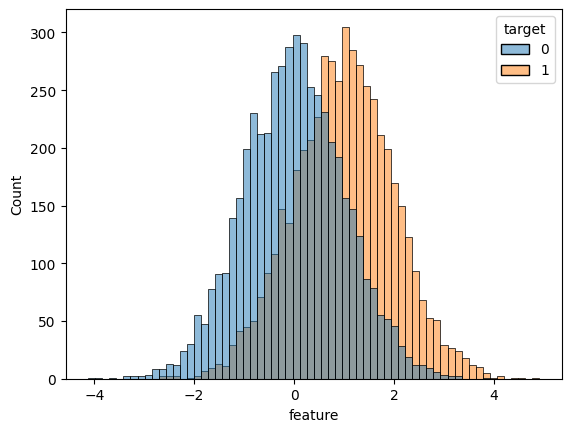

In [ ]:
sns.histplot(df, x = 'feature', hue = 'target')

In [ ]:
# запустите после того, как реализуете все функции
woe_line(values=x, target=y, n_buckets=5)

### Эксперименты (2 балл)

#### №1

Как будут меняться график, метрики разделяющей способности и $R^2$ при изменении дисперсии шума (параметр `noise_std`)?

при уменьшении дисперсии шума в 3 раза:

- AUC +0.2
- IV +7.
- R_sqr +0.003

In [ ]:
noise_std_less = noise_std / 3
x1 = np.concatenate([sps.norm(0, noise_std_less).rvs(size = sample_size // 2), sps.norm(1, noise_std_less).rvs(size = sample_size // 2)])
df['feature_x1'] = x1

In [ ]:
woe_line(values=x1, target=y, n_buckets=5)

при увелечении дисперсии шума в 3 раза:

- AUC -0.2
- IV -0.7
- R_sqr -0.027

In [ ]:
noise_std_high = noise_std * 3
x2 = np.concatenate([sps.norm(0, noise_std_high).rvs(size = sample_size // 2), sps.norm(1, noise_std_high).rvs(size = sample_size // 2)])
df['feature_x2'] = x2

In [ ]:
woe_line(values=x2, target=y, n_buckets=5)


**При уменьшении дисперсии шума:**
   - Разделение на бакеты будет более чётким, так как шум минимален.
   - AUC увеличивается (+0.2) - модель лучше различает классы.
   - IV значительно увеличивается
   - R² незначительно увеличивается

**При увеличении дисперсии шума:**
   - Разделение на бакеты становится менее чётким из-за большого разброса значений.
  - AUC уменьшается (-0.2) - шум затрудняет разделение классов.
  - IV уменьшается (-0.7)
  - R² уменьшается (-0.027) -  шум вносит случайность в данные.


#### №2

Запустите функцию с `values=x ** 2`. Как по графику определить эту ситуацию? Что нужно делать в таком случае?

In [ ]:
woe_line(values=x**2, target=y, n_buckets=5)

Определить такую ситуацию можно по длинному правому хвосту, положительным значениям признака



#### №3

Запустите функцию с `values=np.exp(x)`. Как по графику определить эту ситуацию? Что нужно делать в таком случае?

In [ ]:
woe_line(values=np.exp(x), target=y, n_buckets=5)

видна нелинейность признака, длинный хвост, большая часть данных сконцентрирована в районе 1 можно взять логарифм

## Часть 2. Строим ЛогРег. (5 баллов)

В этом пунтке попробуем применить все наши навыки

Скачайте датасет по [ссылке](https://data.tinkoff.ru/s/Nca7PoTNYokXgNF). Пароль вы найдете в телеграм-канале курса, в посте с анонсом домашки.

In [ ]:
df = pd.read_csv('/content/lr_hw_dataset.csv', index_col=0)
df

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,d4p12
0,-1.444709,3.554779,1.308371,-0.000119,0.029628,3.829880,1,8.825418,3.829880,11.565953,-513.014565,-1.072893,7.936545,0.047069,B,1
1,1.132531,-0.207661,-2.142882,0.062686,0.859062,6.189545,1,3.453220,6.189545,4.935665,-39.351891,3.409855,17.015210,0.029288,A,0
2,1.268781,-0.243999,10000.000000,0.339225,0.614599,12.503629,1,-10.116061,12.503629,6.234414,-4.993050,3.121126,4.878602,0.237255,A,0
3,-1.278475,-2.579890,5.050763,-0.938956,0.090461,-1.080041,1,6.780814,-1.080041,2.682539,-509.273095,-1.242741,20.293025,0.907788,B,0
4,3.507807,0.152661,-8.905005,0.067646,0.216199,1.367184,1,-10.638134,1.367184,6.881602,-2.034797,2.814972,7.352399,0.276854,A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-3.061422,-0.163832,4.812768,-0.949937,0.224437,5.263508,1,-9.959913,5.263508,5.294558,-524.265291,-1.648415,5.410059,0.855190,B,0
99996,0.222451,-0.273191,0.380895,0.860607,0.950708,0.581767,1,-1.645952,0.581767,5.571499,-13.499956,3.386865,92.903615,0.006668,A,1
99997,1.078498,0.339526,-5.184847,0.242072,0.854085,0.995075,1,-5.565932,0.995075,-0.433263,3.928387,3.290285,1.233853,0.160933,A,1
99998,-1.431421,-0.605388,2.466023,-0.056519,0.736255,2.980562,1,-4.517188,2.980562,10.812813,-507.593408,-1.398568,1904.246147,0.077164,B,1


Как вы выдите, ```feature_1, ..., feature_14``` - числа
```feature_15``` - категориальная фича

### Задание 0. EDA.

Как бы вы начали знакомиться с данными до построения модели? Постройте 3-5 графиков / таблиц, чтобы передать основную информацию о датасете.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   feature_1   100000 non-null  float64
 1   feature_2   100000 non-null  float64
 2   feature_3   100000 non-null  float64
 3   feature_4   100000 non-null  float64
 4   feature_5   100000 non-null  float64
 5   feature_6   100000 non-null  float64
 6   feature_7   100000 non-null  int64  
 7   feature_8   100000 non-null  float64
 8   feature_9   100000 non-null  float64
 9   feature_10  100000 non-null  float64
 10  feature_11  100000 non-null  float64
 11  feature_12  100000 non-null  float64
 12  feature_13  100000 non-null  float64
 13  feature_14  100000 non-null  float64
 14  feature_15  100000 non-null  object 
 15  d4p12       100000 non-null  int64  
dtypes: float64(13), int64(2), object(1)
memory usage: 13.0+ MB


In [ ]:
df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,d4p12
0,-1.444709,3.554779,1.308371,-0.000119,0.029628,3.829880,1,8.825418,3.829880,11.565953,-513.014565,-1.072893,7.936545,0.047069,B,1
1,1.132531,-0.207661,-2.142882,0.062686,0.859062,6.189545,1,3.453220,6.189545,4.935665,-39.351891,3.409855,17.015210,0.029288,A,0
2,1.268781,-0.243999,10000.000000,0.339225,0.614599,12.503629,1,-10.116061,12.503629,6.234414,-4.993050,3.121126,4.878602,0.237255,A,0
3,-1.278475,-2.579890,5.050763,-0.938956,0.090461,-1.080041,1,6.780814,-1.080041,2.682539,-509.273095,-1.242741,20.293025,0.907788,B,0
4,3.507807,0.152661,-8.905005,0.067646,0.216199,1.367184,1,-10.638134,1.367184,6.881602,-2.034797,2.814972,7.352399,0.276854,A,0


In [ ]:
df.isnull().sum()

,0
feature_1,0
feature_2,0
feature_3,0
feature_4,0
feature_5,0
feature_6,0
feature_7,0
feature_8,0
feature_9,0
feature_10,0


In [ ]:
numeric_cols = [f'feature_{i}' for i in range(1, 15)]
desc_stats = df[numeric_cols].describe().T
print(desc_stats)

               count        mean          std           min         25%  \
feature_1   100000.0   -0.004065     2.625003 -5.459815e+01   -1.011666   
feature_2   100000.0   -0.198827   169.576125 -3.829617e+04   -0.385200   
feature_3   100000.0   -6.283870  2344.152317 -1.000000e+04   -4.215224   
feature_4   100000.0   -0.125161     0.590046 -1.999985e+00   -0.221922   
feature_5   100000.0    1.001067     1.003677  9.339844e-06    0.287134   
feature_6   100000.0    2.990486     3.997014 -1.873238e+01    0.288999   
feature_7   100000.0    0.900280     0.299628  0.000000e+00    1.000000   
feature_8   100000.0   -2.514795     5.009291 -2.649654e+01   -5.893561   
feature_9   100000.0    2.990486     3.997014 -1.873238e+01    0.288999   
feature_10  100000.0    3.640370     4.977886 -1.684703e+01    0.270052   
feature_11  100000.0 -256.924907   260.742462 -1.012820e+03 -506.548930   
feature_12  100000.0    1.013153     2.314468 -9.210340e+00   -1.262413   
feature_13  100000.0  996

feature_15
B    0.50106
A    0.49894
Name: proportion, dtype: float64


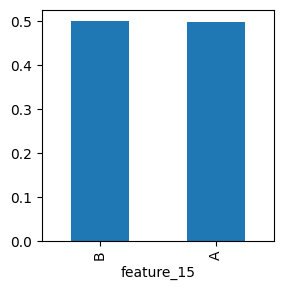

In [ ]:
cat_counts = df['feature_15'].value_counts(normalize=True)
print(cat_counts)
plt.figure(figsize=(3, 3))
cat_counts.plot(kind='bar')
plt.show()

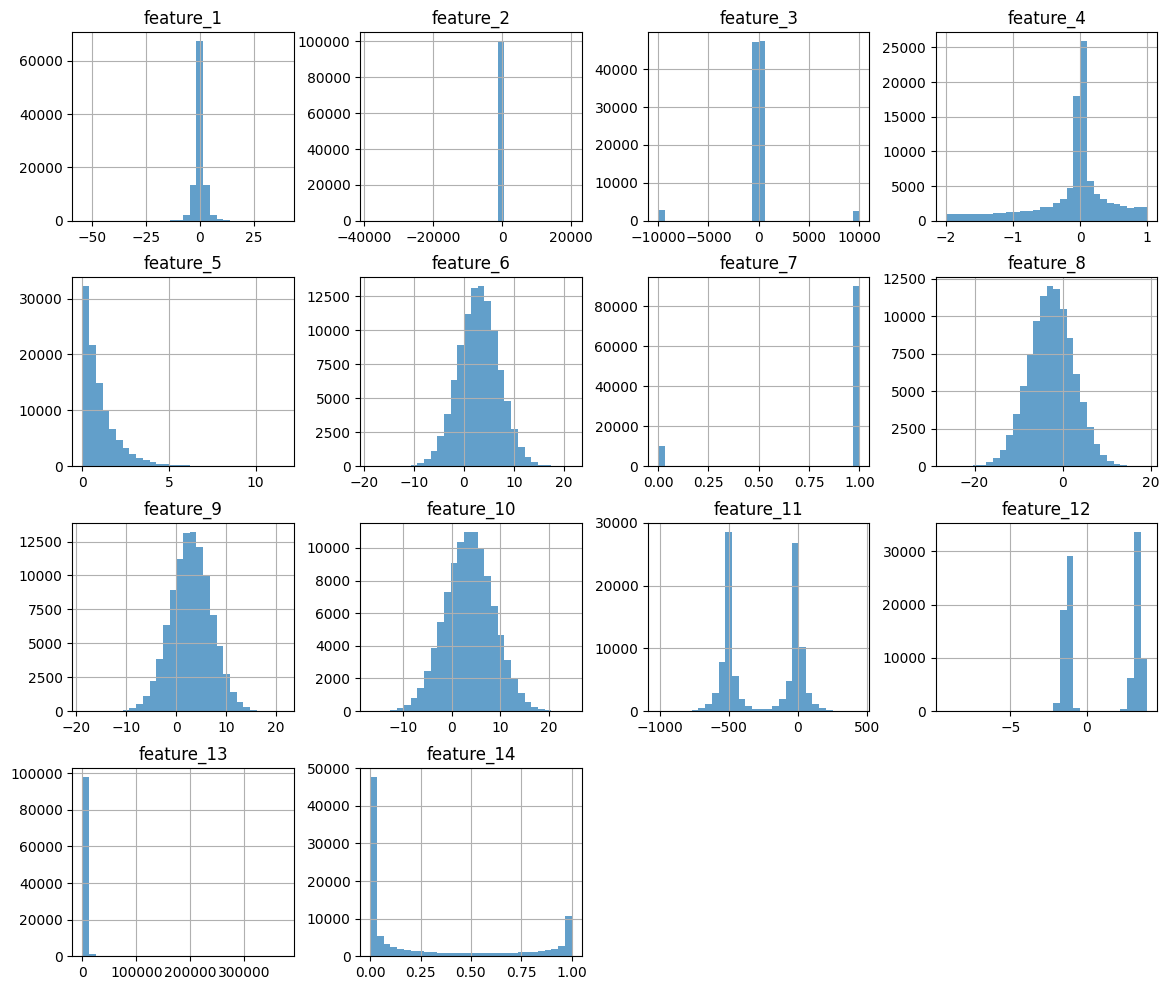

In [ ]:
import matplotlib.pyplot as plt
df[numeric_cols].hist(bins=30, figsize=(14, 12), alpha=0.7)
plt.show()


### Задание 1. Бейзлайн.

Попробуйте построить ЛогРег только на числовых данных. Для этого разбейте датасет на трейн и тест (80/20). Перед обучением логрега стандартизуйте переменные. Это может быть полезно для численной устойчивости алгоритмов оптимизации.

Для этой модели и всех дальнейших:

1. Получилась ли модель линейной? Постройте график линейности на трейне и на тесте и сделайте вывод.
2. Расчитайте AUC и IV на трейне и на тесте. Что можно сказать о переобучении?

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [ ]:
X = df.drop(['d4p12'], axis=1)
y = df['d4p12']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_numeric = X_train[numeric_cols]
X_test_numeric = X_test[numeric_cols]

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_numeric)
X_train_scaled = scaler.transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric)


In [ ]:
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

y_train_pred = model.predict_proba(X_train_scaled)[:, 1]
y_test_pred = model.predict_proba(X_test_scaled)[:, 1]

In [ ]:
woe_line(values=y_train_pred, target=y_train, n_buckets=10)

In [ ]:
woe_line(values=y_test_pred,target=y_test, n_buckets=10)

AUC = 0.708 IV = 0.601 R_sqr = 0.971 - train

AUC = 0.706 IV = 0.600 R_sqr = 0.965 - test

разницы между метриками трейна и тесты малы - переобучение отсутствует

модель линейная

### Задание 2. Добавляем категориальную переменную.

Повторите задание 1, включив в модель категориальную переменную (например, с помощью one-hot encoding).

Улучшилось ли качество?

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False).fit(X_train[['feature_15']].values)
X_enc_15 = enc.transform(X_train[['feature_15']].values)
X_enc_15_test = enc.transform(X_test[['feature_15']].values)

X_train_full = np.hstack([X_train_scaled, X_enc_15])
X_test_full = np.hstack([X_test_scaled, X_enc_15_test])

In [ ]:
model2 = LogisticRegression()
model2.fit(X_train_full, y_train)

y_train_pred_2 = model2.predict_proba(X_train_full)[:, 1]
y_test_pred_2 = model2.predict_proba(X_test_full)[:, 1]

In [ ]:
woe_line(values=y_train_pred_2, target=y_train, n_buckets=10)

In [ ]:
woe_line(values=y_test_pred_2,target=y_test, n_buckets=10)

- переобучения нет
- близко к линейной зависимости, но есть загругление в области 0

сравнение метрик 2х моделей

1 модель

AUC (train): 0.708,
AUC (test): 0.706

IV (train): 0.601,
IV (test): 0.600

2 модель

AUC (train): 0.861,
AUC (test): 0.858

IV (train): 2.268,
IV (test): 2.228


IV значительно стал выше - категориальный признак обладает высокой разделяющей силой


### Задание 3. Линеаризация переменных.

На самом деле, категориальные переменные можно учитывать в моделях совсем по-другому. С их помощью можно выделить в модели сегменты. Каждому сегменту соответствует своя модель (в нашем случае логрег).

Примером такой сегментации может стать сегментация по наличию кредитной истории. В этом случае на разных сегментах будут не просто отдельные модели, но и даже разный изначальный набор признаков. Другое свидетельство удачной сегментации – разный характер зависимости признаков и целевой переменной. Это можно увидеть на графике линейности признака по WoE. Этим мы и займемся далее.

Используйте переменную 15 для сегментации модели. На каждом из двух сегментов линеаризуйте переменные. Для этого приложите:
 - график линейности переменной до преобразования
 - график после подобранного преобразования

Помимо этого:
 - попробуйте линеаризовать какие-нибудь 2 переменные *на всей выборке*. Получилось ли у вас что-то? Постройте график.
 - по графику линейности определите шумовые (либо слабоинформативные) переменные. В конце задания приложите их список.

In [ ]:
categories = X_train['feature_15'].unique()

X_segments_train = {}
y_segments_train = {}
X_segments_test = {}
y_segments_test = {}

for cat in categories:
    train_mask = X_train['feature_15'] == cat
    test_mask = X_test['feature_15'] == cat
    X_segments_train[cat] = X_train[train_mask].drop('feature_15', axis=1)
    y_segments_train[cat] = y_train[train_mask]
    X_segments_test[cat] = X_test[test_mask].drop('feature_15', axis=1)
    y_segments_test[cat] = y_test[test_mask]


In [ ]:
scalers = {}
X_train_scaled_segments = {}
X_test_scaled_segments = {}

for cat in categories:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_segments_train[cat])
    X_test_scaled = scaler.transform(X_segments_test[cat])
    scalers[cat] = scaler
    X_train_scaled_segments[cat] = X_train_scaled
    X_test_scaled_segments[cat] = X_test_scaled


In [ ]:
models = {}
for cat in categories:
    model = LogisticRegression()
    model.fit(X_train_scaled_segments[cat], y_segments_train[cat])
    models[cat] = model
    X_train_seg = X_train_scaled_segments[cat]
    X_test_seg = X_test_scaled_segments[cat]

    y_train_pred = model.predict_proba(X_train_seg)[:, 1]
    y_test_pred = model.predict_proba(X_test_seg)[:, 1]

    print(f"TRAIN - сегмент {cat}")
    fig_train = woe_line(
        values=y_train_pred,
        target=y_segments_train[cat],
        n_buckets=10
    )
    fig_train.show()

    print(f"TEST - сегмент {cat}")
    fig_test = woe_line(
        values=y_test_pred,
        target=y_segments_test[cat],
        n_buckets=10
    )

    fig_test.show()

TRAIN - сегмент B


TEST - сегмент B


TRAIN - сегмент A


TEST - сегмент A


In [ ]:
X_A = X_segments_train['A']
y_A = y_segments_train['A']
X_B = X_segments_train['B']
y_B = y_segments_train['B']
X_A_test = X_segments_test['A']
y_A_test = y_segments_test['A']
X_B_test = X_segments_test['B']
y_B_test = y_segments_test['B']


Преобразование признаков

In [ ]:
import numpy as np


transforms = {
    'log': lambda x: np.log(x.clip(lower=1e-6)),
    'sqrt': lambda x: np.sqrt(x.clip(lower=0)),
    'square': lambda x: x**2,
}


def automate_transformations(df_train, df_test, target, features):
    for col in features:
        print(f"--- Processing {col} ---")

        woe_line(values=df_train[col].values, target=target, n_buckets=10).show()

        for name, func in transforms.items():
            print(f"Testing {name} for {col}")
            transformed_val = func(df_train[col])

            woe_line(values=transformed_val.values, target=target, n_buckets=10).show()


feature_list = [f'feature_{i}' for i in range(2, 15)]

automate_transformations(X_A, X_A_test, y_A, feature_list)



--- Processing feature_2 ---


Testing log for feature_2


Testing sqrt for feature_2


Testing square for feature_2


--- Processing feature_3 ---


Testing log for feature_3


Testing sqrt for feature_3


Testing square for feature_3


--- Processing feature_4 ---


Testing log for feature_4


Testing sqrt for feature_4


Testing square for feature_4


--- Processing feature_5 ---


Testing log for feature_5


Testing sqrt for feature_5


Testing square for feature_5


--- Processing feature_6 ---


Testing log for feature_6


Testing sqrt for feature_6


Testing square for feature_6


--- Processing feature_7 ---


Testing log for feature_7


Testing sqrt for feature_7


Testing square for feature_7


--- Processing feature_8 ---


Testing log for feature_8


Testing sqrt for feature_8


Testing square for feature_8


--- Processing feature_9 ---


Testing log for feature_9


Testing sqrt for feature_9


Testing square for feature_9


--- Processing feature_10 ---


Testing log for feature_10


Testing sqrt for feature_10


Testing square for feature_10


--- Processing feature_11 ---


Testing log for feature_11


Testing sqrt for feature_11


Testing square for feature_11


--- Processing feature_12 ---


Testing log for feature_12


Testing sqrt for feature_12


Testing square for feature_12


--- Processing feature_13 ---


Testing log for feature_13


Testing sqrt for feature_13


Testing square for feature_13


--- Processing feature_14 ---


Testing log for feature_14


Testing sqrt for feature_14


Testing square for feature_14


In [ ]:
def transform_feature_log(val, y):
  fig1 = woe_line(values=val.values, target=y, n_buckets=10)
  fig1.show()
  new = val.clip(lower=-2, upper=6)
  fig2 = woe_line(values=(new.values), target=y, n_buckets=10)
  fig2.show()



transform_feature_log(X_A['feature_6'], y_A)


In [ ]:
X_A['feature_1'] = np.log(X_A['feature_1'])
X_A_test['feature_1'] = np.log(X_A_test['feature_1'])
X_A['feature_2'] = (X_A['feature_2']).clip(lower=-2, upper=2)
X_A_test['feature_2'] = (X_A_test['feature_2']).clip(lower=-2, upper=2)
X_A['feature_3'] = (X_A['feature_3']).clip( upper=2)
X_A_test['feature_3'] = (X_A_test['feature_3']).clip( upper=2)
X_A['feature_5'] = (X_A['feature_5']).clip(upper=5)
X_A_test['feature_5'] = (X_A_test['feature_5']).clip(upper=5)
# X_A['feature_6'] = (X_A['feature_6']).clip(lower=-2, upper=6)
# X_A_test['feature_6'] = (X_A_test['feature_6']).clip(lower=-2, upper=6)
X_A['feature_12'] = (X_A['feature_12'])**2
X_A_test['feature_12'] = (X_A_test['feature_12'])**2
X_A['feature_14'] = np.log(X_A['feature_14'])
X_A_test['feature_14'] = np.log(X_A_test['feature_14'])

In [ ]:
feature_list = [f'feature_{i}' for i in range(1, 15)]
automate_transformations(X_B, X_B_test, y_B, feature_list)

--- Processing feature_1 ---


Testing log for feature_1


Testing sqrt for feature_1


Testing square for feature_1


--- Processing feature_2 ---


Testing log for feature_2


Testing sqrt for feature_2


Testing square for feature_2


--- Processing feature_3 ---


Testing log for feature_3


Testing sqrt for feature_3


Testing square for feature_3


--- Processing feature_4 ---


Testing log for feature_4


Testing sqrt for feature_4


Testing square for feature_4


--- Processing feature_5 ---


Testing log for feature_5


Testing sqrt for feature_5


Testing square for feature_5


--- Processing feature_6 ---


Testing log for feature_6


Testing sqrt for feature_6


Testing square for feature_6


--- Processing feature_7 ---


Testing log for feature_7


Testing sqrt for feature_7


Testing square for feature_7


--- Processing feature_8 ---


Testing log for feature_8


Testing sqrt for feature_8


Testing square for feature_8


--- Processing feature_9 ---


Testing log for feature_9


Testing sqrt for feature_9


Testing square for feature_9


--- Processing feature_10 ---


Testing log for feature_10


Testing sqrt for feature_10


Testing square for feature_10


--- Processing feature_11 ---


Testing log for feature_11


/tmp/ipython-input-3086550939.py:53: RuntimeWarning:

invalid value encountered in subtract

/tmp/ipython-input-3086550939.py:55: RuntimeWarning:

invalid value encountered in subtract



Testing sqrt for feature_11


/tmp/ipython-input-3086550939.py:53: RuntimeWarning:

invalid value encountered in subtract

/tmp/ipython-input-3086550939.py:55: RuntimeWarning:

invalid value encountered in subtract



Testing square for feature_11


--- Processing feature_12 ---


Testing log for feature_12


Testing sqrt for feature_12


Testing square for feature_12


--- Processing feature_13 ---


Testing log for feature_13


Testing sqrt for feature_13


Testing square for feature_13


--- Processing feature_14 ---


Testing log for feature_14


Testing sqrt for feature_14


Testing square for feature_14


In [ ]:
def transform_feature_log(val, y):
  fig1 = woe_line(values=val.values, target=y, n_buckets=10)
  fig1.show()
  new = val.clip(lower=0)
  fig2 = woe_line(values=(new.values), target=y, n_buckets=10)
  fig2.show()



transform_feature_log(X_B['feature_3'], y_B)


In [ ]:
X_B['feature_2'] = (X_B['feature_2']).clip(lower=-2, upper=2)
X_B_test['feature_2'] = (X_B_test['feature_2']).clip(lower=-2, upper=2)
X_B['feature_3'] = (X_B['feature_3']).clip(lower=0)
X_B_test['feature_3'] = (X_B_test['feature_3']).clip(lower=0)
X_B['feature_14'] = np.log(X_B['feature_14'])
X_B_test['feature_14'] = np.log(X_B_test['feature_14'])

In [ ]:
scalers = {}
X_train_scaled_segments = {}
X_test_scaled_segments = {}

for cat in categories:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_segments_train[cat])
    X_test_scaled = scaler.transform(X_segments_test[cat])
    scalers[cat] = scaler
    X_train_scaled_segments[cat] = X_train_scaled
    X_test_scaled_segments[cat] = X_test_scaled


In [ ]:
models = {}
for cat in categories:
    model = LogisticRegression()
    model.fit(X_train_scaled_segments[cat], y_segments_train[cat])
    models[cat] = model
    X_train_seg = X_train_scaled_segments[cat]
    X_test_seg = X_test_scaled_segments[cat]

    y_train_pred = model.predict_proba(X_train_seg)[:, 1]
    y_test_pred = model.predict_proba(X_test_seg)[:, 1]

    print(f"TRAIN - сегмент {cat}")
    fig_train = woe_line(
        values=y_train_pred,
        target=y_segments_train[cat],
        n_buckets=10
    )
    fig_train.show()

    print(f"TEST - сегмент {cat}")
    fig_test = woe_line(
        values=y_test_pred,
        target=y_segments_test[cat],
        n_buckets=10
    )

    fig_test.show()

TRAIN - сегмент B


TEST - сегмент B


TRAIN - сегмент A


TEST - сегмент A


### Задание 4. Финальная модель.

Обучите модели на признаках, которые вы отобрали и линеаризовали в задании 3. Пусть $logit_A$ – модель, обученная на сегменте $feature_{15} = A$. $logit_B$ – модель на втором сегменте. Тогда модель на всей выборке будем считать по формуле

$$
logit(x) = \mathbb I \{ feature_{15} = A \} \times logit_A(x) + \mathbb I \{ feature_{15} = B \} \times logit_B(x)
$$


Посчитайте для этой модели AUC и IV, оцените линейность на трейне и тесте. Сравните результаты с бейзлайном из задания 1.

Подсказка: если вы все сделали правильно, можно ожидать ROC AUC около 0.9 на тестовой выборке.

In [ ]:
train_preds_list = []
test_preds_list = []

for cat in categories:
    model = models[cat]

    prob_train = model.predict_proba(X_train_scaled_segments[cat])[:, 1]
    prob_test = model.predict_proba(X_test_scaled_segments[cat])[:, 1]

    train_preds_list.append(pd.Series(prob_train, index=y_segments_train[cat].index))
    test_preds_list.append(pd.Series(prob_test, index=y_segments_test[cat].index))

full_train_preds = pd.concat(train_preds_list).sort_index()
full_test_preds = pd.concat(test_preds_list).sort_index()

y_train_sorted = y_train.sort_index()
y_test_sorted = y_test.sort_index()


woe_line(values=full_train_preds.values, target=y_train_sorted.values, n_buckets=10).show()
woe_line(values=full_test_preds.values, target=y_test_sorted.values, n_buckets=10).show()


AUC = 0.879 IV = 2.733 R_sqr = 0.939 


In [ ]:
print('Train', calc_plot_title(
    values=full_train_preds.values,
    target=y_train_sorted.values,
    buckets=calc_buckets(full_train_preds,10)
))
print('Test', calc_plot_title(
    values=full_test_preds.values,
    target=y_test_sorted.values,
    buckets=calc_buckets(full_test_preds,10)
))

Train AUC = 0.882 IV = 2.787 R_sqr = 0.945 
Test AUC = 0.879 IV = 2.733 R_sqr = 0.939 


метрики модели из Бейзлайна на тесте:
AUC = 0.706

IV = 0.600


финальная модель:

Test AUC = 0.879

IV = 2.733


AUC и IV заметно увеличились

# Часть 3. Бонус. (3 балла)

На лекции мы накопили ряд упражнений, которые стоит решить для понимания происходившего. Вы можете $\TeX$ать их прямо в ноуте (или прикреплять картинки, если так удобнее).

#### **Упражнение 1**

Для определения $WoE$ мы пользовались Теоремой Байеса. Примените ее и **покажите, что верно равенство**:

$$
\ln \left(  \frac{P(x_i|y=1)}{P(x_i|y=0)} \right) = ... = \ln \left( \frac{P(y=1|x_i)}{P(y=0|x_i)} \right) - \ln \left( \frac{P(y=1)}{P(y=0)} \right)
$$

Применим теорему Байеса к числителю и  к знаменателю, получаем:
$$= \ln \left(\frac{P(y = 1 | x_i)P(x_i)P(y=0)}{P(y=1)P(x_i)P(y=0|x_i)}\right) = \ln \left( \frac{P(y = 1 | x_i)}{P(y=0|x_i)  }\div \frac{P(y=1)}{P(y=0)} \right) = \\ \ln \left( \frac{P(y=1|x_i)}{P(y=0|x_i)} \right) - \ln \left( \frac{P(y=1)}{P(y=0)} \right)
$$


#### **Упражнение 2**

Известно:

$WoE$ можно посчитать так:
$WoE_i(x_i) = \ln \Big ( \frac{B_i}{G_i} \Big ) - \ln \Big ( \frac{B}{G} \Big ) $

Частота выхода в дефолт:  $badrate = \frac{B}{B+G}; \quad badrate_i = \frac{B_i}{B_i+G_i}$

$
\sigma (x) = \frac{1}{1+e^{-x}}; \quad logit(x) = \ln \left( \frac{x}{1-x} \right)
$

**Покажите, что**
$WoE_i(x_i) = logit(badrate_i) - logit(badrate)$

$$
  badrate = \frac{B}{B+G} \\ \Rightarrow 1 - badrate = 1 - \frac{B}{B+G} = \frac{B+G-B}{B+G} = \frac{G}{B+G}\\
 logit(badrate)= ln \left( \frac{b}{1 - b} \right) = ln \left( \frac{B}{(B+G)}\div \frac{G}{(B+G)}\right) = \ln \left( \frac{B}{G} \right)
$$
аналогично для $$logit(badrate_i)=\ln \left( \frac{B_i}{G_i}\right)$$
отсюда верно $WoE_i(x_i) = \ln \Big ( \frac{B_i}{G_i} \Big ) - \ln \Big ( \frac{B}{G} \Big ) = logit(badrate_i) - logit(badrate)$

#### **Упражнение 3**

Пусть даны два дискретных распределения:

$B=(b_1, ..., b_n)$ и $G=(g_1, ..., g_n)$.

KL-дивергенция для дискретных распределений

$$D_{KL}(B||G) = \sum_{j=1}^{n} b_j \ln \left( \frac{b_j}{g_j} \right)$$


Пусть $x$ - дикретный признак, принмиающий значения $x_1,...,x_n$.
Известно определение IV через KL-дивергенцию:

$$
IV_x = D_{KL}(B_x||G_x)+D_{KL}(G_x||B_x)
$$
где

$$
B_x (x_i) = P(x=x_i|y=1) = b_i; \quad G_x (x_i) = P(x=x_i|y=0) = g_i
$$

**Выразите $IV$ через $WoE$**





```
your solution here
```